In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append(r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\Python_scripts")

from kinumaax.source.kinumaax import learning as kl
from kinumaax.source.kinumaax import visualization as kv
from kinumaax.source.kinumaax import crunching as kc

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

import mpl_defaults
from matplotlib import gridspec

import qrcode
from qrcode.image.styles.moduledrawers import GappedSquareModuleDrawer
from qrcode.image.styledpil import StyledPilImage

from sklearn.ensemble import (
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

import pyrolite.comp


# where all the figures get dumped
export_path = r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures"

plt.rcParams["font.family"] = "CMU Sans Serif"

# qr code package
#https://github.com/lincolnloop/python-qrcode


In [2]:
data = pd.read_excel(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Mendenhall\Data\B4_major_trace_data_combined.xlsx"
)
iodp_data = pd.read_excel(r"C:\Users\jlubbers\OneDrive - DOI\Research\Mendenhall\Data\IODP_round1_major_trace_data_combined.xlsx")

usgs_logo_path = r"C:\Users\jlubbers\OneDrive - DOI\Research\Mendenhall\Presentations\USGS_logo_green.png"
pipeline_fig_path = r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures\ML_pipeline_diagram.png"
voting_fig_path = r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures\ML_voting_classifier_schematic.png"

qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_L)
qr.add_data("https://github.com/jlubbersgeo/goldschmidt_2022")
qr_code = qr.make_image(
    image_factory=StyledPilImage,
    module_drawer=GappedSquareModuleDrawer(),
)

qr_gs = qrcode.QRCode(error_correction = qrcode.constants.ERROR_CORRECT_L)
qr_gs.add_data("https://conf.goldschmidt.info/goldschmidt/2022/meetingapp.cgi/Paper/11299")
qr_gs_code = qr_gs.make_image(image_factory=StyledPilImage,
    module_drawer=GappedSquareModuleDrawer(),
)


usgs_logo = plt.imread(usgs_logo_path)
pipeline_fig = plt.imread(pipeline_fig_path)



In [3]:
trace_elements = data.loc[:, "7Li":"238U"].columns.tolist()
trace_elements.remove('51V')
trace_elements.remove('65Cu')
major_elements = data.loc[:,'SiO2':'P2O5'].columns.tolist()
data = kc.remove_strings(
    data,
    ignore_cols=[
        "Sample_shard",
        "timestamp",
        "experiment",
        "eruption",
        "volcano",
        "AT_num",
        "Spot",
        "lat",
        "lon",
    ],
)
nan_elements, nan_counts = kc.df_checkna(df=data, cols=trace_elements)
print("These are the columns that have nans and their values")
for element, count in zip(nan_elements, nan_counts):
    print(element, count)

data = data.set_index('volcano')
volcanoes = data.index.unique().tolist()

data.shape


These are the columns that have nans and their values
7Li 4
31P 21
43Ca 1
66Zn 1
133Cs 1
139La 1
147Sm 11
153Eu 11
157Gd 19
163Dy 14
166Er 24
172Yb 35
178Hf 3
181Ta 27


(1666, 96)

In [4]:
data = kc.df_dropna(df = data, cols = nan_elements)
data = kc.df_oxide_to_ppm(data,oxides = major_elements)
major_elements_ppm = [column for column in data.columns if "ppm" in column]

In [5]:
data = kc.filter_by_value(data,col_name = 'Ti_ppm',value = 0,operator = 'greater_than')
data = kc.filter_by_value(data,col_name = 'Mn_ppm',value = 0,operator = 'greater_than')
data = kc.filter_by_value(data,col_name = 'P_ppm',value = 0,operator = 'greater_than')
# adding ratios to dataframe
data['Sr/Y'] = data['88Sr'] / data['89Y'] # adakite distinguishing ratio # possible source w/ garnet
data['total_alkalis'] = data['Na2O'] + data['K2O'] # alkaline magma 
data['Zr/Y'] = data['90Zr'] / data['89Y'] # continental vs oceanic arc
data['Zr/Nb'] = data['90Zr'] / data['93Nb'] # incompatible elements
data['Zr/Hf'] = data['90Zr'] / data['178Hf'] # similar incompatible elements
data['Nb/U'] = data['93Nb'] / data['238U'] # similar incompatible elements
data['Nb/Y'] = data['93Nb'] / data['89Y'] # arc vs intraplate
data['Nb/Ta'] = data['93Nb'] / data['181Ta'] # similar incompatible elements
data['Ba/La'] = data['137Ba'] / data['139La'] # tracer of slab fluid in magma
data['Ba/Nb'] = data['137Ba'] / data['93Nb'] # source heterogeneities
data['La/Nb'] = data['139La'] / data['93Nb'] # incompatible elements
data['Rb/Ba'] = data['85Rb'] / data['137Ba'] # similar incompatible elements
data['La/Yb'] = data['139La'] / data['172Yb'] #similar incompatible elements
data['Th/Yb'] = data['232Th'] / data['172Yb'] # tracer of subducted sediment in arc magma (Plank 2005)
data['Th/La'] = data['232Th'] / data['139La'] # Derkachev et al 2018 ratio
data['Ce/Pb'] = data['140Ce'] / data['208Pb'] # similar incompatible elements
ratios = data.loc[:,'Sr/Y':].columns.tolist()


iodp_data = pd.read_excel(r"C:\Users\jlubbers\OneDrive - DOI\Research\Mendenhall\Data\IODP_round1_major_trace_data_combined.xlsx")
iodp_data = kc.remove_strings(iodp_data,ignore_cols = ['timestamp', 'experiment', 'IODP_sample', 'Spot',])
iodp_data = kc.df_dropna(df = iodp_data, cols = trace_elements)
iodp_data['Age (yrs)'] = np.ceil(iodp_data['Age (yrs)'])
iodp_data['Sr/Y'] = iodp_data['88Sr'] / iodp_data['89Y'] # adakite distinguishing ratio # possible source w/ garnet
iodp_data['total_alkalis'] = iodp_data['Na2O'] + iodp_data['K2O'] # alkaline magma 
iodp_data['Zr/Y'] = iodp_data['90Zr'] / iodp_data['89Y'] # continental vs oceanic arc
iodp_data['Zr/Nb'] = iodp_data['90Zr'] / iodp_data['93Nb'] # incompatible elements
iodp_data['Zr/Hf'] = iodp_data['90Zr'] / iodp_data['178Hf'] # similar incompatible elements
iodp_data['Nb/U'] = iodp_data['93Nb'] / iodp_data['238U'] # similar incompatible elements
iodp_data['Nb/Y'] = iodp_data['93Nb'] / iodp_data['89Y'] # arc vs intraplate
iodp_data['Nb/Ta'] = iodp_data['93Nb'] / iodp_data['181Ta'] # similar incompatible elements
iodp_data['Ba/La'] = iodp_data['137Ba'] / iodp_data['139La'] # tracer of slab fluid in magma
iodp_data['Ba/Nb'] = iodp_data['137Ba'] / iodp_data['93Nb'] # source heterogeneities
iodp_data['La/Nb'] = iodp_data['139La'] / iodp_data['93Nb'] # incompatible elements
iodp_data['Rb/Ba'] = iodp_data['85Rb'] / iodp_data['137Ba'] # similar incompatible elements
iodp_data['La/Yb'] = iodp_data['139La'] / iodp_data['172Yb'] #similar incompatible elements
iodp_data['Th/Yb'] = iodp_data['232Th'] / iodp_data['172Yb'] # tracer of subducted sediment in arc magma (Plank 2005)
iodp_data['Th/La'] = iodp_data['232Th'] / iodp_data['139La'] # Derkachev et al 2018 ratio
iodp_data['Ce/Pb'] = iodp_data['140Ce'] / iodp_data['208Pb'] # similar incompatible elements
iodp_data = kc.df_oxide_to_ppm(iodp_data,oxides = major_elements)

iodp_data.set_index('IODP_sample',inplace = True)

In [6]:
df = pd.DataFrame(data.loc[:,major_elements_ppm + trace_elements + ratios],index = data.index)
clr_df = df.pyrocomp.CLR()
clr_df.head()

iodp_df = iodp_data.loc[:,major_elements_ppm + trace_elements + ratios]
iodp_clr_df = iodp_df.pyrocomp.CLR()
iodp_clr_df.head()

CLR(Si_ppm/G)  CLR(Ti_ppm/G)  CLR(Al_ppm/G)  CLR(Fe_ppm/G)  \
IODP_sample                                                                    
U1417D-1H-1W_3-5       9.228195       3.187629       7.807988       5.539724   
U1417D-1H-1W_3-5       9.170944       3.130378       7.750737       5.482473   
U1417D-1H-1W_3-5       9.211570       3.171003       7.791363       5.523099   
U1417D-1H-1W_3-5       9.205692       3.165126       7.785486       5.517221   
U1417D-1H-1W_3-5       9.194281       3.153715       7.774074       5.505810   

                  CLR(Mn_ppm/G)  CLR(Mg_ppm/G)  CLR(Ca_ppm/G)  CLR(Na_ppm/G)  \
IODP_sample                                                                    
U1417D-1H-1W_3-5       2.992374       2.763720       5.032177       7.297187   
U1417D-1H-1W_3-5       2.935123       2.706469       4.974926       7.239936   
U1417D-1H-1W_3-5       2.975748       2.747095       5.015552       7.280562   
U1417D-1H-1W_3-5       2.969871       2.741217       5.009674       7.274684   
U1417D-1H-1W_3-5       2.958460       2.729806       4.998263       7.263273   

                  CLR(K_ppm/G)  CLR(P_ppm/G)  ...  CLR(Nb/Y/G)  CLR(Nb/Ta/G)  \
IODP_sample                                   ...                              
U1417D-1H-1W_3-5      7.127778      0.845037  ...    -5.717880     -0.961626   
U1417D-1H-1W_3-5      7.070527      0.787786  ...    -5.803208     -0.741659   
U1417D-1H-1W_3-5      7.111153      0.828412  ...    -5.712720     -1.006795   
U1417D-1H-1W_3-5      7.105276      0.822535  ...    -5.794063     -0.891495   
U1417D-1H-1W_3-5      7.093864      0.811123  ...    -5.796343     -0.990024   

                  CLR(Ba/La/G)  CLR(Ba/Nb/G)  CLR(La/Nb/G)  CLR(Rb/Ba/G)  \
IODP_sample                                                                
U1417D-1H-1W_3-5      0.364025      1.678474     -2.260682     -6.289207   
U1417D-1H-1W_3-5      0.270975      1.630954     -2.272403     -6.433175   
U1417D-1H-1W_3-5      0.364748      1.621296     -2.335209     -6.311789   
U1417D-1H-1W_3-5      0.340271      1.680203     -2.257701     -6.351515   
U1417D-1H-1W_3-5      0.346703      1.660184     -2.295565     -6.368778   

                  CLR(La/Yb/G)  CLR(Th/Yb/G)  CLR(Th/La/G)  CLR(Ce/Pb/G)  
IODP_sample                                                               
U1417D-1H-1W_3-5     -2.305980     -3.546976     -4.816128     -2.508798  
U1417D-1H-1W_3-5     -2.328509     -3.496291     -4.800165     -2.469631  
U1417D-1H-1W_3-5     -2.334934     -3.482574     -4.739397     -2.461286  
U1417D-1H-1W_3-5     -2.221436     -3.394171     -4.770369     -2.504401  
U1417D-1H-1W_3-5     -2.320044     -3.497739     -4.786740     -2.486022  

[5 rows x 55 columns]

In [7]:
rs = 10  # for reproducibility

# instantiate model with algorithm type, # of estimators,
# max depth of the trees, and fix the random state
rf_model = kl.tephraML(name="random forest model")
rf_model.instantiate(
    model_type="random_forest", n_estimators=500,max_depth = 5, random_state=rs
)
# assign data to the model
# creates attribute model.data
rf_model.get_data(clr_df.reset_index())

# split into training and test data. Target and features
# not yet chosen
rf_model.split_data(test_size=0.3, random_state=rs)



myfeatures = clr_df.columns.tolist()


# split training and test data into target and features
# creates model.training_feature_data, model.training_target_data
# model.test_feature_data, and model.test_target_data attributes
rf_model.get_train_test_data(feature_cols=myfeatures, target_col="volcano")

rf_model.train_model()
rf_model.predict()

rf_model.get_feature_importance(kind="permutation", n_iterations=10, n_jobs=-1)
rf_model.make_confusion_matrix(normalize = "true")
rf_model.get_prediction_probability()
rf_model.get_cross_val_score(stratified=True, n_splits=3, shuffle=True, random_state=rs)

rf_iodp_predictions = pd.DataFrame(rf_model.model.predict_proba(iodp_clr_df), columns = [f"{c}_rf_proba" for c in rf_model.model.classes_],index = iodp_data.index)

Accuracy on training set: 0.990
Accuracy on test set: 0.976
Accuracy of prediction: 0.976
Cross-validation mean: 0.98 | std: 0.0


In [8]:


etc = ExtraTreesClassifier(random_state=rs,n_jobs = 8,max_depth = 5)
rfc = RandomForestClassifier(random_state=rs,n_jobs = 8,max_depth = 5)
gbc = GradientBoostingClassifier(random_state=rs)
knc = KNeighborsClassifier(n_jobs = 8)
svc = SVC(random_state=rs,probability = True)
lda = LinearDiscriminantAnalysis()


vcs = VotingClassifier(
    estimators=[
        ("et", etc),
        ("rf", rfc),
        ("gbt", gbc),
        ("knn", knc),
        ("svc", svc),
        ("lda", lda),
    ],
    voting="soft",
)

vcs.fit(rf_model.training_feature_data,rf_model.training_target_data)
# iodp_scaled_data = pd.DataFrame(rf_model.scaler.transform(iodp_data.loc[:, myfeatures]),index = iodp_data.index,columns = [f"{feature}_scaled" for feature in myfeatures])

soft_predictions = pd.DataFrame(vcs.predict_proba(iodp_clr_df), columns = [f"{c}_vcs_proba" for c in rf_model.model.classes_],index = iodp_data.index)
iodp_data = pd.concat([iodp_data,rf_iodp_predictions,soft_predictions],axis = 'columns')
iodp_data.insert(4,"vcs_predicted_volcano",vcs.predict(iodp_clr_df))
iodp_data.insert(5,"rf_predicted_volcano",rf_model.model.predict(iodp_clr_df))


In [9]:
X = np.array(rf_model.training_feature_data)
y = rf_model.training_target_data

iodp_samples = iodp_data.index.unique().tolist()
layer_ages = []
for sample in iodp_samples:
    layer_ages.append(iodp_data.loc[sample,'Age (yrs)'].unique()[0])
iodp_data.reset_index(inplace = True)
iodp_byage = iodp_data.set_index('Age (yrs)')
iodp_data.set_index('IODP_sample',inplace = True)

lats = data['lat'].unique()
lons = data['lon'].unique()
loc_list = []
for source, lat,lon in zip(volcanoes, lats, lons):
    loc_list.append([lat,lon,source])

sorted_locations = np.array(sorted(loc_list,key = lambda x: int(x[1])))

In [10]:
iodp_clr_df['Age'] = iodp_data['Age (yrs)'].to_numpy()


In [11]:
# text for the poster
# intro box
bullet_one = "$\\bullet$ Of the ~130 volcanoes < 2Ma in Alaska, ~30 have produced a large tephra-\n$\\quad$producing eruption (LTPE), and some multiple times."
bullet_two = "$\\bullet$ Due to glacial erosion in the last ice age, much of the proximal volcanic\n$\\quad$record is limited to the Holocene."
bullet_three = "$\\bullet$ Establishing long-term LTPE frequency, critical for more accurate hazard\n$\\quad$forecasting, therefore, necessitates the use of the distal tephra record."
bullet_four = ("$\\bullet$ We present a new model that accurately links distal tephra deposits\n$\\quad$from ocean drill cores in the Gulf of Alaska to their most probable "
               "source\n$\\quad$volcano by using a combination of in situ geochemistry and machine\n$\\quad$learning.")
bullet_five = "$\\bullet$ We apply our model to tephra layers in IODP cores U1417 and U1418 to\n$\\quad$better constrain the long-term volcanic history of the Gulf of Alaska."
bullet_list = [bullet_one, bullet_two, bullet_three, bullet_four, bullet_five]


# conclusion box
conc_bullet_one = "$\\bullet$ Incompatible trace element ratios are useful at distinguishing Aleutian\n$\\quad$tephras."
conc_bullet_two = "$\\bullet$ Proximal tephras with known sources from across the Alaska-Aleutian arc\n$\\quad$can be used to train machine learning models and applied to distal deposits."
conc_bullet_three = ("$\\bullet$ We have developed a system designed to grow and 'learn' as more\n$\\quad$data become available, aiding in our "
                     "understanding of the frequency at\n$\\quad$which these volcanoes have potentially hazardous LTPEs.")
conc_bullet_list = [conc_bullet_one, conc_bullet_two, conc_bullet_three]

# Forward looking box
lr_bullet_one = "$\\bullet$ More training data! Currently there are some known holes in our source\n$\\quad$dataset that need to be filled (i.e., more ELVC, Seguam, Fisher, Atka)."
lr_bullet_two = "$\\bullet$ Continue to improve feature engineering to find the best features\n$\\quad$or geochemical ratios that differentiate Aleutian tephras."
lr_bullet_three = ("$\\bullet$ Continue gathering TE data on more IODP tephra samples. Within U1417\n$\\quad$and U1418 there are ~60 more < 1Ma. This is crucial "
                     "for understanding\n$\\quad$ LTPE frequency in the Gulf of AK.")
lr_bullet_list = [lr_bullet_one, lr_bullet_two, lr_bullet_three]

acknowledgement_text = ("This poster was made using the Python package matplotlib. Thank you to John D. Hunter for developing such a wonderful tool and the open\nsource"
                       "community for making it is what it is today. This project would not be possible without the decades of excellent work done by "
                       "countless\nUSGS scientists and partners over the decades.")
data_explain_text = ("$\\bullet$ Characterizing Aleutian tephra geochemistry using incompatible trace element\n$\\quad$ratios helps remove " 
                     "problems related to data reduction inconsistencies while\n$\\quad$being petrologically significant! These data are in "
                     "situ measurements generated\n$\\quad$via EPMA and LA-ICPMS.")

model_explain_text = ("$\\bullet$ We use conceptually different classifier algorithms (i.e. high vs low variance\n$\\quad$and bias) to determine predicted class. "
                      "The largest overall probability (P)\n$\\quad$between all algorithms wins! This balances out strengths and weaknesses\n$\\quad$of each algorithm.")

application_text = ("$\\bullet$ We applied our model to 19 tephra layers from IODP cores U1417 and U1418\n$\\quad$in the Gulk of AK to generate probabilistic estimates "
                    "of their source volcano.\n$\\quad$Some good and some not so good fits are shown below.")

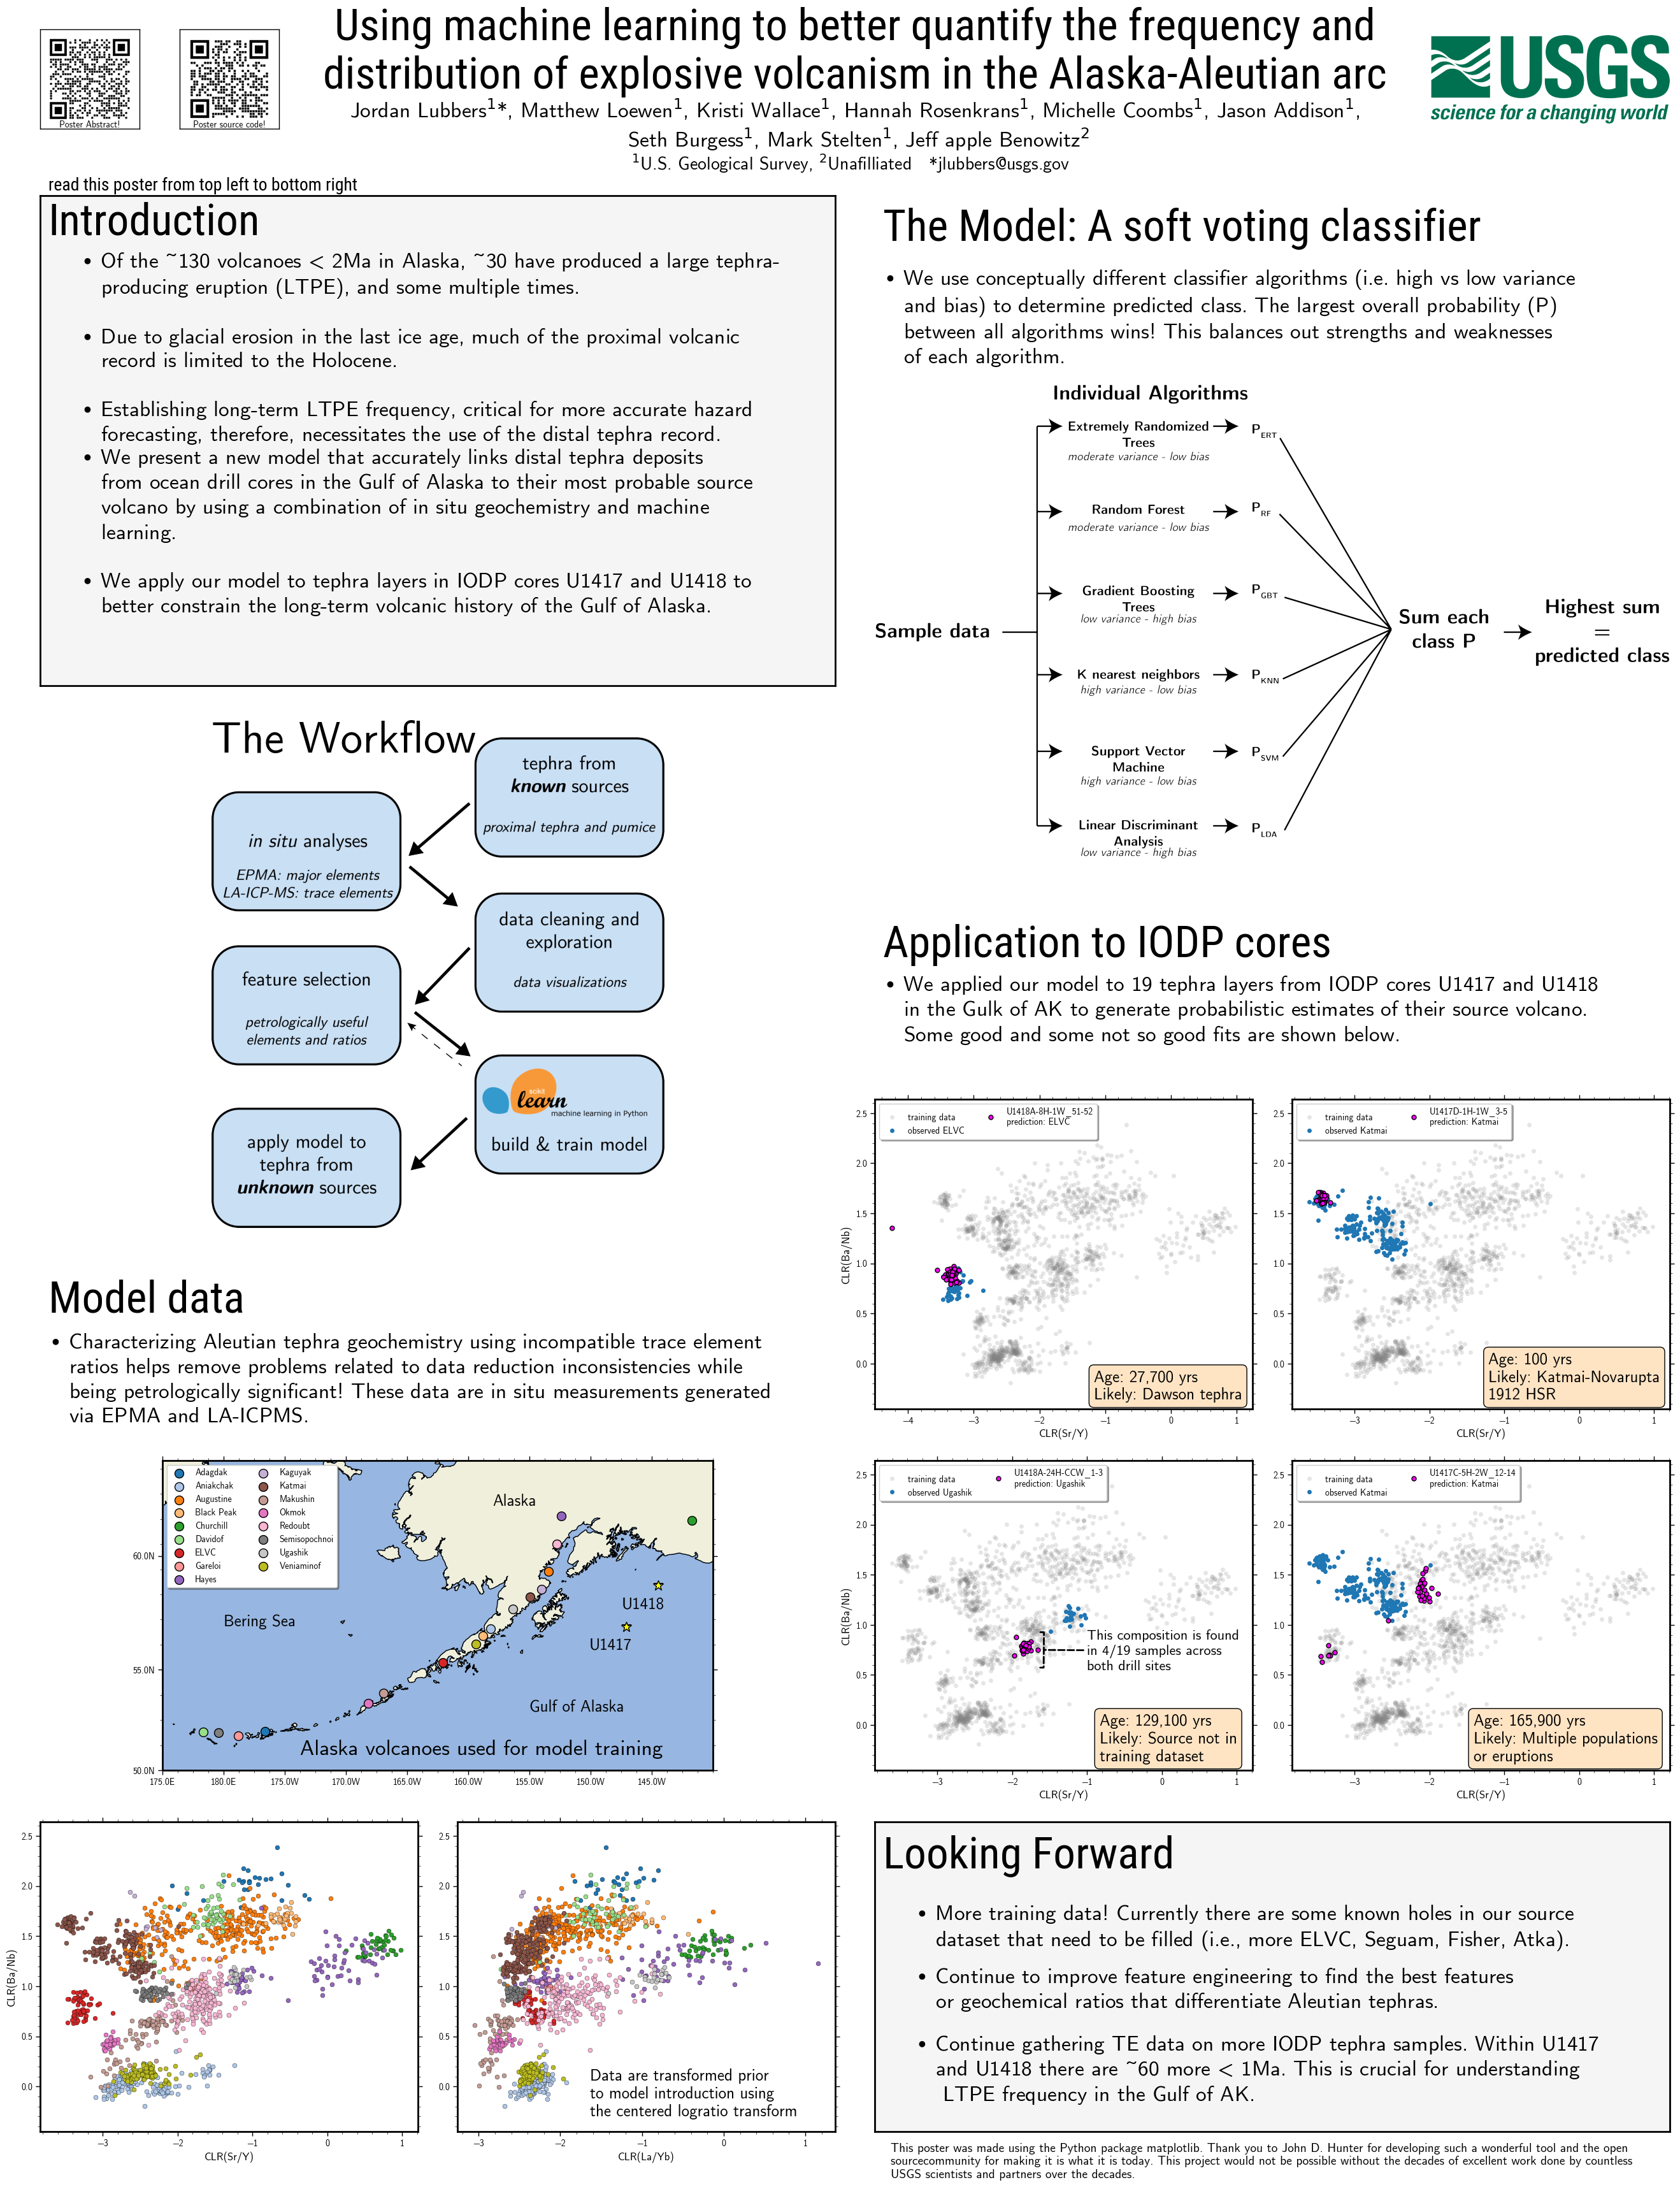

In [13]:
bkgd_color = "gainsboro"
text_box_color = "whitesmoke"
header_font = "Roboto Condensed"
center_longitude = 180
cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
colorlist = [cmap(i) for i in range(len(volcanoes))]
fig = plt.figure(figsize=(33,44))
gspec = gridspec.GridSpec(
    ncols=12,
    nrows=12,
    figure=fig,
    width_ratios=np.full(12, 1 / 12),
    height_ratios=np.full(12, 1 / 12),
    wspace=0.4,
    hspace=0.4,
)

# title and authors
ax_title = plt.subplot(
    gspec[0, 2:10], frameon=False, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)
# left most logo
ax_title_left_left = plt.subplot(gspec[0, 0], frameon=True, xticks=[], yticks=[])
ax_title_left_left.imshow(qr_gs_code)
ax_title_left_left.text(
    0.5,
    0.0,
    "Poster Abstract!",
    horizontalalignment="center",
    verticalalignment="bottom",
    transform=ax_title_left_left.transAxes,
)

ax_title_left = plt.subplot(gspec[0, 1], frameon=True, xticks=[], yticks=[])
ax_title_left.imshow(qr_code)
ax_title_left.text(
    0.5,
    0.0,
    "Poster source code!",
    horizontalalignment="center",
    verticalalignment="bottom",
    transform=ax_title_left.transAxes,
)

ax_title_right = plt.subplot(gspec[0, 10:], frameon=False, xticks=[], yticks=[])
ax_title_right.imshow(usgs_logo)
ax_title_right.set_facecolor(bkgd_color)


# upper left
ax_ul = plt.subplot(
    gspec[1:4, :6], frameon=True, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)
# middle left
ax_ml = plt.subplot(gspec[4:7, :6], frameon=False, xticks=[], yticks=[])
# ax_ll_caption = plt.subplot(gspec[5, :4], frameon=False, xticks=[], yticks=[])

# lower left caption
ax_ll_caption = plt.subplot(
    gspec[7, :6], frameon=False, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)
# lower left top map
ax_lltl = plt.subplot(
    gspec[8:10, :6], projection=ccrs.Mercator(central_longitude=center_longitude)
)

# lower left lower left
ax_llll = plt.subplot(gspec[10:12, :3])
# lower left lower right
ax_lllr = plt.subplot(gspec[10:12, 3:6])

# upper right caption
ax_ur_caption = plt.subplot(
    gspec[1, 6:], frameon=False, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)

# upper right diagram
ax_ur = plt.subplot(gspec[2:5, 6:], frameon=False, xticks=[], yticks=[])

# # upper right caption/ title text
ax_mr_caption = plt.subplot(
    gspec[5, 6:], frameon=False, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)
# upper right top left
ax_mrtl = plt.subplot(gspec[6:8, 6:9])
# upper right top right
ax_mrtr = plt.subplot(gspec[6:8, 9:])
# upper right lower left
ax_mrll = plt.subplot(gspec[8:10, 6:9])
# upper right lower right
ax_mrlr = plt.subplot(gspec[8:10, 9:])

# bottom right
ax_lr = plt.subplot(
    gspec[10:12, 6:], frameon=True, xlim=[0, 1], xticks=[], ylim=[0, 1], yticks=[]
)



# Build a rectangle in axes coords
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height
middle = 0.5 * (left + right)

ax_title.text(
    middle,
    top * 0.95,
    "Using machine learning to better quantify the frequency and\ndistribution of explosive volcanism in the Alaska-Aleutian arc",
    transform=ax_title.transAxes,
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=50,
    name=header_font,
)
ax_title.text(
    middle,
    top * 0.2,
    (
        "Jordan Lubbers$^1$*, Matthew Loewen$^1$, Kristi Wallace$^1$, Hannah Rosenkrans$^1$, Michelle Coombs$^1$, Jason Addison$^1$,\n"
        " Seth Burgess$^1$, Mark Stelten$^1$, Jeff apple Benowitz$^2$"
    ),
    transform=ax_title.transAxes,
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=24,
)
ax_title.text(
    0.992 * middle,
    top * -0.2,
    "$^1$U.S. Geological Survey, $^2$Unafilliated$\\quad$*jlubbers@usgs.gov",
    transform=ax_title.transAxes,
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=20,
)

################################################################################
# INTRO PANEL
ax_ul.text(
    0.01, 0.92, "Introduction", fontsize=50, transform=ax_ul.transAxes, name=header_font
)
ax_ul.text(
    0.01,
    1.01,
    "read this poster from top left to bottom right",
    fontsize=20,
    transform=ax_ul.transAxes,
    name=header_font,
)


ax_ul.text(
    0.05, 0.8, bullet_list[0], transform=ax_ul.transAxes, fontsize=24,
)

ax_ul.text(
    0.05, 0.65, bullet_list[1], transform=ax_ul.transAxes, fontsize=24,
)
ax_ul.text(
    0.05, 0.5, bullet_list[2], transform=ax_ul.transAxes, fontsize=24,
)
ax_ul.text(
    0.05, 0.3, bullet_list[3], transform=ax_ul.transAxes, fontsize=24,
)
ax_ul.text(
    0.05, 0.15, bullet_list[4], transform=ax_ul.transAxes, fontsize=24,
)
ax_ul.set_facecolor(text_box_color)
[x.set_linewidth(2) for x in ax_ul.spines.values()]
#############################################################################
# MIDDLE LEFT AXIS
img = plt.imread(pipeline_fig_path)
ax_ml.imshow(img)
ax_ml.text(0, 0.97, "The Workflow", fontsize=50, transform=ax_ml.transAxes)
#############################################################################
# LOWER LEFT CAPTION
ax_ll_caption.text(
    0.01,
    0.75,
    "Model data",
    fontsize=50,
    transform=ax_ll_caption.transAxes,
    name=header_font,
)
ax_ll_caption.text(
    0.01, -0.1, data_explain_text, fontsize=24, transform=ax_ll_caption.transAxes,
)

############################################################################
# LOWER LEFT MAP
extent = [175, 220, 50, 62]

sct_params = {"ec": "k", "cmap": "Reds"}
cbar_params = {"shrink": 0.4, "pad": 0.02}
# # add geoaxes and set extent with lat and lon ticks

ax_lltl.set_extent(extent)
ax_lltl.coastlines(linewidth=1)
ax_lltl.set_xticks(np.arange(extent[0], extent[1], 5), crs=ccrs.PlateCarree())
ax_lltl.set_yticks(np.arange(extent[2], extent[3], 5), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(
    number_format=".1f", degree_symbol="", dateline_direction_label=True
)
lat_formatter = LatitudeFormatter(number_format=".1f", degree_symbol="")
ax_lltl.xaxis.set_major_formatter(lon_formatter)
ax_lltl.yaxis.set_major_formatter(lat_formatter)

# add land and ocean features
ax_lltl.add_feature(cfeature.LAND)
ax_lltl.add_feature(cfeature.OCEAN)

# add thick border around edge
ax_lltl.spines["geo"].set_linewidth(2)
for volcano, color in zip(volcanoes, colorlist):
    ax_lltl.scatter(
        data.loc[volcano, "lon"].unique()[0],
        data.loc[volcano, "lat"].unique()[0],
        color=color,
        ec="k",
        marker="o",
        label=volcano,
        s=100,
        transform=ccrs.PlateCarree(),
    )

ax_lltl.legend(
    loc="upper left",
    bbox_to_anchor=(0, 1),
    ncol=2,
    framealpha=1,
    facecolor="w",
    frameon=True,
    fancybox=True,
    shadow=True,
)

# u1417 lat: 56°57.5996′N lon: 147°6.5985′W
ax_lltl.plot(
    -147.11,
    56.959,
    marker="*",
    ms=12,
    mec="k",
    mfc="yellow",
    transform=ccrs.PlateCarree(),
)
ax_lltl.text(
    -147.11 - 3, 56.959 - 1, "U1417", transform=ccrs.PlateCarree(), fontsize=18
)


# U1418 lat: 58°46.6095′N lon: 144°29.5777′W
ax_lltl.plot(
    -144.492,
    58.777,
    marker="*",
    ms=12,
    mec="k",
    mfc="yellow",
    transform=ccrs.PlateCarree(),
)
ax_lltl.text(
    -144.492 - 3, 58.777 - 1, "U1418", transform=ccrs.PlateCarree(), fontsize=18
)
ax_lltl.text(-180, 57, "Bering Sea", transform=ccrs.PlateCarree(), fontsize=18)
ax_lltl.text(-155, 53, "Gulf of Alaska", transform=ccrs.PlateCarree(), fontsize=18)
ax_lltl.text(-158, 62, "Alaska", transform=ccrs.PlateCarree(), fontsize=18)
ax_lltl.text(
    0.25,
    0.05,
    "Alaska volcanoes used for model training",
    transform=ax_lltl.transAxes,
    fontsize=24,
)
######################################################################################
#  LOWER LEFT LOWER LEFT
elx = "Sr/Y"
ely = "Ba/Nb"
for volcano, color in zip(volcanoes, colorlist):
    ax_llll.plot(
        clr_df.loc[volcano, f"CLR({elx}/G)"],
        clr_df.loc[volcano, f"CLR({ely}/G)"],
        ls="",
        mec="k",
        marker="o",
        label=volcano,
        mfc=color,
        ms=5,
        mew=0.25,
    )

ax_llll.set_xlabel(f"CLR({elx})")
ax_llll.set_ylabel(f"CLR({ely})")
[x.set_linewidth(2) for x in ax_llll.spines.values()]



#  UPPER MIDDLE LOWER LEFT
elx = "La/Yb"
ely = "Ba/Nb"
for volcano, color in zip(volcanoes, colorlist):
    ax_lllr.plot(
        clr_df.loc[volcano, f"CLR({elx}/G)"],
        clr_df.loc[volcano, f"CLR({ely}/G)"],
        ls="",
        mec="k",
        marker="o",
        label=volcano,
        mfc=color,
        ms=5,
        mew=0.25,
    )

ax_lllr.set_xlabel(f"CLR({elx})")
ax_lllr.text(
    0.35,
    0.05,
    "Data are transformed prior\nto model introduction using\nthe centered logratio transform",
    transform=ax_lllr.transAxes,
    fontsize=18,
)
[x.set_linewidth(2) for x in ax_lllr.spines.values()]

##############################################################################
# UPPER RIGHT DIAGRAM CAPTION
ax_ur_caption.text(
    0.01,
    0.65,
    "The Model: A soft voting classifier",
    fontsize=50,
    transform=ax_ur_caption.transAxes,
    name=header_font,
)
ax_ur_caption.text(
    0.01, -0.3, model_explain_text, fontsize=24, transform=ax_ur_caption.transAxes,
)

###############################################################################
# UPPER RIGHT DIAGRAM
img2 = plt.imread(voting_fig_path)
ax_ur.imshow(img2)
##############################################################################
# MIDDLE RIGHT CAPTION
# UPPER RIGHT AXIS CAPTION
ax_mr_caption.text(
    0.01,
    0.7,
    "Application to IODP cores",
    fontsize=50,
    transform=ax_mr_caption.transAxes,
    name=header_font,
)
ax_mr_caption.text(
    0.01, 0.05, application_text, fontsize=24, transform=ax_mr_caption.transAxes,
)
#################################################################################
# MIDDLE RIGHT PLOTS
# UPPER RIGHT 4 plots. Plotting the same thing but with different
# samples so we use a loop!
dawson_sample = iodp_samples[5]
novarupta_sample = iodp_samples[0]
ugashik_sample = iodp_samples[8]
mixed_sample = iodp_samples[15]
likely_text = [
    "Dawson tephra",
    "Katmai-Novarupta\n1912 HSR",
    "Source not in\ntraining dataset",
    "Multiple populations\nor eruptions",
]


elx = "Sr/Y"
ely = "Ba/Nb"
training_color = "gray"
obs_color = "C0"
unk_color = "fuchsia"
ms = 5
arrowprops = dict(arrowstyle="-[", color="k", linewidth=2, ls="--", mutation_scale=20)
for a, sample, prediction, text, x in zip(
    [ax_mrtl, ax_mrtr, ax_mrll, ax_mrlr],
    [dawson_sample, novarupta_sample, ugashik_sample, mixed_sample],
    ["ELVC", "Katmai", "Ugashik", "Katmai"],
    likely_text,
    [.58,.52,.595,.48]
):
    a.plot(
        clr_df[f"CLR({elx}/G)"],
        clr_df[f"CLR({ely}/G)"],
        marker="o",
        ms = ms,
        ls="",
        mfc=training_color,
        mec="none",
        alpha=0.2,
        label="training data",
    )
    a.plot(
        clr_df.loc[prediction, f"CLR({elx}/G)"],
        clr_df.loc[prediction, f"CLR({ely}/G)"],
        marker="o",
        ms = ms,
        ls="",
        mfc=obs_color,
        mew=0,
        label=f"observed {prediction}",
    )

    a.plot(
        iodp_clr_df.loc[sample, f"CLR({elx}/G)"],
        iodp_clr_df.loc[sample, f"CLR({ely}/G)"],
        marker="o",
        ms = ms,
        mfc=unk_color,
        mec="k",
        ls="",
        label=f"{sample}\nprediction: {prediction}",
    )
    a.set_xlabel(f"CLR({elx})")
    if sample is dawson_sample or sample is ugashik_sample:
        
        a.set_ylabel(f"CLR({ely})")
        
    a.legend(
            loc="upper left",
            bbox_to_anchor=(0, 1),
            ncol=2,
            framealpha=1,
            facecolor="w",
            frameon=True,
            fancybox=True,
            shadow=True,
        )
    a.text(
        x,
        0.03,
        f"Age: {int(iodp_data.loc[sample,'Age (yrs)'].unique()[0]):,} yrs\nLikely: {text}",
        transform=a.transAxes,
        fontsize=18,
        bbox=dict(facecolor='bisque', edgecolor='k', boxstyle='round')
    )
    if sample is ugashik_sample:
        a.annotate(
            "This composition is found\nin 4/19 samples across\nboth drill sites",
            xy=(-1.6, 0.75),
            xytext=(-1, 0.55),
            arrowprops=arrowprops,
            fontsize=16,
        )
    [x.set_linewidth(2) for x in a.spines.values()]

        
###########################################################################
# LOWER RIGHT TEXT BOX
# Discussion/moving forward panel
ax_lr.text(
    0.01,
    0.85,
    "Looking Forward",
    fontsize=50,
    transform=ax_lr.transAxes,
    name=header_font,
)
ax_lr.text(
    0.05, 0.6, lr_bullet_list[0], transform=ax_lr.transAxes, fontsize=24,
)

ax_lr.text(
    0.05, 0.4, lr_bullet_list[1], transform=ax_lr.transAxes, fontsize=24,
)
ax_lr.text(
    0.05, 0.1, lr_bullet_list[2], transform=ax_lr.transAxes, fontsize=24,
)
ax_lr.set_facecolor(text_box_color)
ax_lr.text(0.02, -0.15, acknowledgement_text, fontsize=14)
[x.set_linewidth(2) for x in ax_lr.spines.values()]
plt.savefig("{}\GS_verticalposter_Final.pdf".format(export_path), bbox_inches="tight")
plt.savefig("{}\GS_verticalposter_Final.png".format(export_path), bbox_inches="tight")